In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import model
import os
import sys
import time
import datetime
import dataloader
import os
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, Compose
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import torch
import torch.nn as  nn
import torch.nn.functional as F
import torch
import  torchvision
from torchvision.transforms import Lambda
from torchvision.transforms import v2
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA

/tmp/ipykernel_549414/911076731.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import model
from model import ResNet50
from dataloader import MILDataset
import torch
from sklearn.model_selection import train_test_split

In [3]:
train_data=pd.read_csv('trainset/trainset_true.csv')
train_df, test_df = train_test_split(train_data,
                                             test_size=0.4,
                                             random_state=999,
                                             shuffle=True,
                                             stratify=train_data.LABEL)

In [4]:
train_df.LABEL.value_counts()

LABEL
1    67
0    30
Name: count, dtype: int64

In [5]:
def Add_PCA_noise(image):
    img_array=np.array(image)
    original_shape = img_array.shape
    img_array = img_array.reshape(-1, 3).astype(np.float32)
    mean = np.mean(img_array, axis=0)
    img_array_centered = img_array - mean
    pca = PCA(n_components=3)
    pca.fit(img_array_centered)
    noise = np.random.normal(0, 0.1, (1, 3)) * np.sqrt(pca.explained_variance_)
    new_image_centered = img_array_centered + noise
    new_image = new_image_centered + mean
    new_image=new_image.reshape(original_shape)
    new_image_clipped = np.clip(new_image, 0, 255).astype(np.uint8)
    return Image.fromarray(new_image_clipped)

identity_transform = Lambda(lambda x: x)

transform = v2.Compose([Add_PCA_noise,
    v2.RandomChoice([
    v2.RandomRotation((0, 0)),
    v2.RandomRotation((90, 90)),
    v2.RandomRotation((180, 180)),
    v2.RandomRotation((270, 270))]),v2.RandomChoice([v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),identity_transform]),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

/users/eleves-b/2020/damien.vilcocq/.local/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [6]:
train_dataset = MILDataset(root_dir='trainset/',
                         df=train_df,
                         transform=transform)


val_dataset = MILDataset(root_dir='trainset/',
                         df=test_df,
                         transform=transforms.Compose([v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))


train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=4)

/users/eleves-b/2020/damien.vilcocq/.local/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [7]:
import torch.nn as nn
import torch

from torch import Tensor
from typing import Type

class BasicBlock(nn.Module):
    """Basic Block for ResNet18 and ResNet34"""
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        stride: int = 1,
        expansion: int = 1,
        downsample: nn.Module = None
    ) -> None:
        super(BasicBlock, self).__init__()
        # Multiplicative factor for the subsequent conv2d layer's output channels.
        # It is 1 for ResNet18 and ResNet34.
        self.expansion = expansion
        self.downsample = downsample
        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            out_channels,
            out_channels*self.expansion,
            kernel_size=3,
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels*self.expansion)
    def forward(self, x: Tensor) -> Tensor:
        identity = x # store copy of input tensor
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity # add input tensor to output tensor - residual connection
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(
        self,
        img_channels: int, # either grayscale or RGB images
        num_layers: int,K: int,
        block: Type[BasicBlock],
        num_classes: int = 1000, average='mean'
    ) -> None:
        super(ResNet, self).__init__()
        if num_layers == 18:
            # The following `layers` list defines the number of `BasicBlock`
            # to use to build the network and how many basic blocks to stack
            # together.
            layers = [1, 1, 1, 1]
            self.expansion = 1
        self.in_channels = K
        # All ResNets (18 to 152) contain a Conv2d => BN => ReLU for the first
        # three layers. Here, kernel size is 7.
        self.conv1 = nn.Conv2d(
            in_channels=img_channels,
            out_channels=self.in_channels,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False
        )
        self.average=average
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, K, layers[0])
        self.layer2 = self._make_layer(block, K*2, layers[1], stride=2)
        self.layer3 = self._make_layer(block, K*4, layers[2], stride=2)
        self.layer4 = self._make_layer(block, K*8, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(7*7*8*K*self.expansion, num_classes)
    def _make_layer(
        self,
        block: Type[BasicBlock],
        out_channels: int,
        blocks: int,
        stride: int = 1
    ) -> nn.Sequential:
        downsample = None
        if stride != 1:
            """
            This should pass from `layer2` to `layer4` or 
            when building ResNets50 and above. Section 3.3 of the paper
            Deep Residual Learning for Image Recognition
            (https://arxiv.org/pdf/1512.03385v1.pdf).
            """
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    out_channels*self.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(out_channels * self.expansion),
            )
        layers = [] # for storing the layers
        layers.append(
            block(
                self.in_channels, out_channels, stride, self.expansion, downsample
            )
        )
        self.in_channels = out_channels * self.expansion
        for i in range(1, blocks):
            layers.append(block(
                self.in_channels,
                out_channels,
                expansion=self.expansion
            ))
        return nn.Sequential(*layers)
    def forward(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # The spatial dimension of the final layer's feature
        # map should be (7, 7) for all ResNets.
        # print('Dimensions of the last convolutional feature map: ', x.shape)
        #x = self.avgpool(x)
        
        x = torch.flatten(x, 1)
        #print(x.shape)
        if self.average=='mean':
            x = torch.mean(x, dim=0)
        return x


In [8]:
class CNN_net(nn.Module):
    def __init__(self, K, num_classes=2, channels=3, average='mean'):
        super(CNN_net, self).__init__()
        # Supposons que ResNet et BasicBlock sont définis ailleurs correctement.
        self.ResNet = ResNet(img_channels=channels, num_layers=18, K=K, block=BasicBlock, num_classes=num_classes, average=average)
        self.fc = nn.Linear(K*8*7*7, num_classes)

    def forward(self, bag_images):
        x = self.ResNet(bag_images)
        #print(x.shape, 'sortie mean')
        x = self.fc(x)
        #print(x.shape, 'sortie linear')
        x = torch.log_softmax(x, dim=0)
        #print(x.shape, 'sortie softmax')
        return x

In [9]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [10]:
from tqdm import tqdm
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix, balanced_accuracy_score
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_uniform_(m.weight)



In [22]:
batch_size=50
epochs=400
l_balanced_acc_train=[]
l_balanced_acc_val=[]
list_train_loss=[]
list_val_loss=[]
print_frequency = 10
save_frequency = 10
save_model = True
K=8
lr=0.0001
final_model=CNN_net(K=K, average='mean', num_classes=2).to('cuda')
final_model.apply(init_weights)
optimizer = torch.optim.Adam(final_model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=0.0005)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)
best_val_balanced_acc = 0
loss_fn = nn.NLLLoss()
loss=0
save_model = True
len_current_batch=0
for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
    if epoch%100==0 and epoch!=0:
        lr=lr/10
        optimizer = torch.optim.Adam(final_model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=0.0005)
    #print('******** Epoch [{}/{}]  ********'.format(epoch+1, epochs))
    final_model.train()
    #print('Training')
    train_loss=0
    
    all_labels_train=[]
    all_preds_train=[]
    for i, data in (enumerate(train_loader)):
        
        
        len_current_batch+=1
        inputs, labels = data
        #print(inputs['id'])
        images=inputs['instances'][0].cuda()
        labels=labels.cuda()
        outputs = final_model(images)
        
   
        _, preds = torch.max(outputs.unsqueeze(0), 1)
        all_preds_train.extend(preds.cpu().numpy())
        all_labels_train.extend(labels.cpu().numpy())
        if preds==0:
            loss+=loss_fn(outputs.unsqueeze(0),labels)
        else:
            loss+=loss_fn(outputs.unsqueeze(0),labels)
        #print(len_current_batch)
        if len_current_batch==batch_size:
            optimizer.zero_grad()
            train_loss+=loss.item()
            loss=loss/len_current_batch
            loss.backward()
            optimizer.step()
            len_current_batch=0
            loss=0
        if i==len(train_loader)-1 and len_current_batch!=0:

            train_loss+=loss.item()
            #print('end of one batch')
    list_train_loss.append(train_loss/len(train_loader))
    #print('Validation')
    val_loss=0
    with torch.no_grad():   # Disable gradient computation (faster and saves memory)
        final_model.eval()        # Disable Dropout and BatchNormalization
        all_preds = []
        all_labels = []
        for k, data in enumerate(val_loader):
            inputs, labels = data
            images=inputs['instances'][0].cuda()
            outputs=final_model(images).cuda()
            labels=labels.cuda()
            loss=loss_fn(outputs.unsqueeze(0), labels)
            _, preds = torch.max(outputs.unsqueeze(0), 1)  # Get the index of the max log-probability as the prediction
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            if preds==0:
                val_loss+=loss.item()
            else:
                val_loss+=loss.item()
        list_val_loss.append(val_loss/len(val_loader))
        scheduler.step(val_loss)
        #scheduler.step(val_loss/len(val_loader))
        balanced_acc = balanced_accuracy_score(all_labels, all_preds)
        accuracy = accuracy_score(all_labels, all_preds)
        if balanced_acc > best_val_balanced_acc:
            best_val_balanced_acc = balanced_acc
            best_model = final_model    
                
        # Calcul de la matrice de confusion
        tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
        
        # Calcul du taux de vrais positifs (sensibilité) et de faux négatifs
        sensitivity = tp / (tp + fn)
        false_negative_rate = fn / (fn + tp)
        
        # Calcul de l'accuracy équilibrée
        balanced_acc = balanced_accuracy_score(all_labels, all_preds)
        balanced_acc_train = balanced_accuracy_score(all_labels_train, all_preds_train)
        #list_val_loss.append(val_loss)
        l_balanced_acc_val.append(balanced_acc)
        l_balanced_acc_train.append(balanced_acc_train)
    
    # Journalisation
        print('Epoch [{}/{}] train_loss: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}, val_sensitivity: {:.4f}, val_FNR: {:.4f}, val_balanced_acc: {:.4f}, train_balanced_acc: {:.4f}, lr:{:.2e}'.format(
        epoch+1, epochs, train_loss/len(train_loader), val_loss/len(val_loader), accuracy, sensitivity, false_negative_rate, balanced_acc,balanced_acc_train, optimizer.param_groups[0]['lr']))
if save_model:
    torch.save(best_model.state_dict(), 'best_model.pt')
plt.plot(list_train_loss, label='train_loss')
plt.plot(list_val_loss, label='val_loss')


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:08<?, ?it/s]


In [12]:
torch.save(final_model.state_dict(), './models/final_model_b=30_100epochs_lr=0_001_K=32.pt')

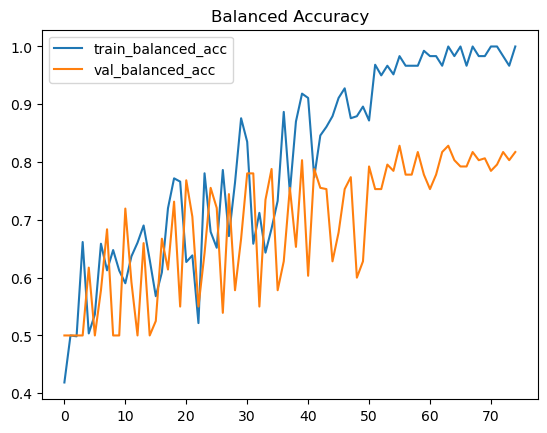

In [13]:
plt.title('Balanced Accuracy')
plt.plot(l_balanced_acc_train, label='train_balanced_acc')
plt.plot(l_balanced_acc_val, label='val_balanced_acc')
plt.legend()

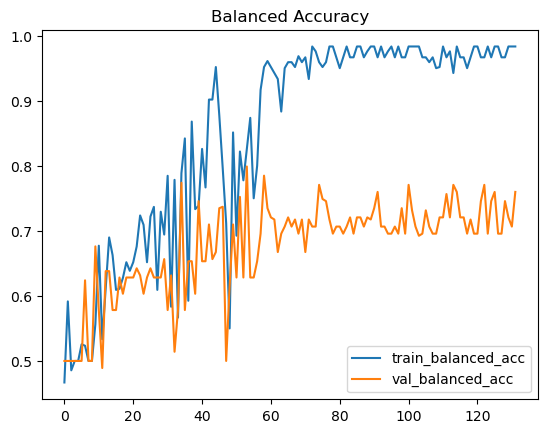

In [22]:
plt.title('Balanced Accuracy')
plt.plot(l_balanced_acc_train, label='train_balanced_acc')
plt.plot(l_balanced_acc_val, label='val_balanced_acc')
plt.legend()

In [26]:
torch.max(images[0])

tensor(1., device='cuda:0')

## Submitting 

In [16]:
def metadata_build(df_train): 
    df_train['GENDER'] = df_train.GENDER.apply(lambda x: int(x == 'F'))
    df_train['DOB'] = df_train['DOB'].apply(lambda x: x.replace("-", "/"))
    df_train['AGE'] = df_train['DOB'].apply(
        lambda x: 2023-int(x.split("/")[-1]))
    return df_train

db_test = pd.read_csv('/users/eleves-b/2020/damien.vilcocq/Desktop/DL/testset/testset_data.csv')

test_dataset = MILDataset(root_dir='testset/',
                         df=df_test,
                         transform=transforms.Compose([v2.ToTensor(),v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)
test_pred = pd.DataFrame(columns = ["ID","Predicted"])
model_test = CNN_net(K=K, average='mean', num_classes=2)
model_test.load_state_dict(torch.load('./models/final_model_b=30_100epochs_lr=0_001_K=32.pt'))
model_test.eval()
with torch.no_grad():
    for X, target, id in DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False):
        log_probs = model_test(X)
        y_pred = torch.argmax(log_probs, dim=1)
        test_pred["Predicted"] = y_pred
        test_pred["ID"] = id

pd.DataFrame.to_csv(test_pred, "./submissions/test_pred.csv", index=False)

NameError: name 'df_test' is not defined

In [18]:
df_test = pd.read_csv('/users/eleves-b/2020/damien.vilcocq/Desktop/DL/testset/testset_data.csv')

test_dataset = MILDataset(root_dir='testset/',
                         df=df_test,
                         transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)
model_test = final_model
model_test.eval()  # Assurez-vous que le modèle est en mode évaluation

test_pred = pd.DataFrame(columns = ["ID","Predicted"])
with torch.no_grad():
    for i, data in (enumerate(test_loader)):
        inputs, labels = data
        #print(inputs['id'])
        images=inputs['instances'][0].cuda()
        labels=labels.cuda()
        outputs = model_test(images)
        _, preds = torch.max(outputs.unsqueeze(0), 1)
        test_pred.loc[i] = [inputs['id'][0], preds.cpu().numpy()[0]]
print(test_pred)
pd.DataFrame.to_csv(test_pred, "./submissions/test_pred4.csv", index=False)

      ID  Predicted
0   P108          1
1   P114          1
2   P119          1
3   P120          1
4   P132          1
5   P133          1
6   P138          1
7   P139          1
8    P14          1
9   P143          1
10  P148          0
11  P152          1
12   P16          1
13  P170          1
14  P172          1
15  P175          1
16  P178          0
17   P18          0
18  P188          1
19  P195          1
20  P196          1
21  P197          0
22  P203          0
23   P24          1
24   P32          1
25    P4          1
26   P49          1
27   P56          1
28   P57          0
29   P58          1
30   P68          0
31   P69          1
32    P7          0
33   P71          1
34   P73          1
35   P75          1
36   P81          0
37   P86          1
38    P9          1
39   P92          1
40   P93          1
41   P98          0


In [ ]:
db_test = pd.read_csv('/users/eleves-b/2020/aurelien.stumpf-mascles/Code/DLMI/challenge/DL/testset/testset_data.csv')
db_test = metadata_build(db_test)
dataset_test = Test_Dataset(db_test)

test_pred = pd.DataFrame(columns = ["ID","Predicted"])
model_test = Model1()
model_test.load_state_dict(torch.load('./models/best_model_0.86.pt'))
model_test.eval()
with torch.no_grad():
    for X, target, id in DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False):
        log_probs = model_test(X)
        y_pred = torch.argmax(log_probs, dim=1)
        test_pred["Predicted"] = y_pred
        test_pred["ID"] = id

pd.DataFrame.to_csv(test_pred, "./submissions/test_pred.csv", index=False)

NameError: name 'metadata_build' is not defined

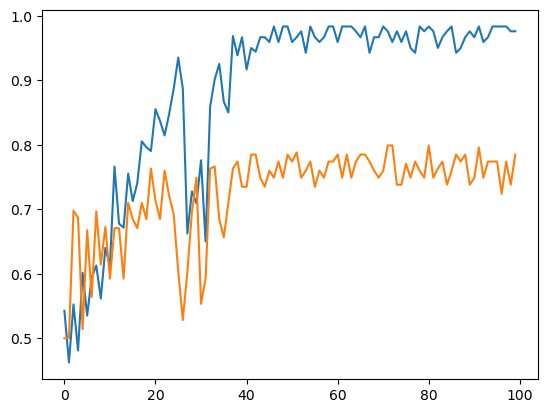

In [ ]:
plt.title('Balanced Accuracy')
plt.plot(l_balanced_acc_train, label='train_balanced_acc')
plt.plot(l_balanced_acc_val, label='val_balanced_acc')
plt.legend()

In [140]:
import numpy as np
import torch

# Initialiser une liste pour stocker toutes les images redimensionnées
all_images = []
c=1
for i, data in enumerate(train_loader):

    inputs, labels = data
    images = inputs['instances'][0]  # Assurez-vous que cela correspond à la structure de vos données
    #print(images.shape[0])
    # Redimensionner les images et les convertir en numpy arrays
    reshaped=images.permute(0,2, 3, 1)
    #print(reshaped.shape)
    reshaped=reshaped.reshape((reshaped.shape[0]*224*224, 3)).cpu().numpy()
    
    # Ajouter les images redimensionnées à la liste
    all_images.append(reshaped)
    if c==0: 
        break
# Concaténer toutes les images dans un seul array numpy
all_images_np = np.concatenate(all_images, axis=0)
all_images_np -= np.mean(all_images_np, axis=0)
# Calculer la matrice de covariance sur l'ensemble des pixels de toutes les images
# La forme attendue pour `all_images_np` est [nombre_de_pixels_total, 3]
cov_matrix = np.cov(all_images_np, rowvar=False)

print("Matrice de covariance calculée :", cov_matrix)


Matrice de covariance calculée : [[0.03722173 0.04118414 0.01741583]
 [0.04118414 0.04600077 0.01934702]
 [0.01741583 0.01934702 0.00879108]]


In [141]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(all_images_np)
v = pca.components_
lamb=pca.explained_variance_
v, lamb

(array([[ 0.6450485 ,  0.5510994 ,  0.5293407 ],
        [-0.07588964, -0.6430998 ,  0.7620128 ],
        [-0.7603639 ,  0.53170687,  0.3730079 ]], dtype=float32),
 array([1.38323812e+00, 7.83057730e-03, 2.42604245e-04]))

In [139]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(all_images_np)
v = pca.components_
lamb=pca.explained_variance_
v, lamb

(array([[-0.64287126, -0.7040341 , -0.30174816],
        [ 0.03481377, -0.42038924,  0.9066756 ],
        [ 0.76518226, -0.5723705 , -0.29476625]], dtype=float32),
 array([0.10362316, 0.00088063, 0.00018781], dtype=float32))

In [111]:
noise=np.random.normal(0, 0.1, (1, 3))*np.sqrt(pca.explained_variance_)

In [125]:
lamb=pca.explained_variance_

In [127]:
lamb/256**2

array([0.07992773, 0.00046201, 0.00012512])

In [107]:
cov_matrix = np.cov(all_images_np, rowvar=False)
eigen_values, eigen_vectors = np.linalg.eig(cov_matrix)

In [108]:
eigen_values, eigen_vectors

(array([0.09124663, 0.00019325, 0.0005737 ]),
 array([[-0.6376087 , -0.75100895, -0.17158293],
        [-0.70909981,  0.65920365, -0.25025589],
        [-0.30105251,  0.03789591,  0.95285428]]))

In [32]:
images.shape
reshape=images.permute(0,2, 3, 1)
reshape=reshape.view((images.shape[0]*224*224, 3)).cpu().numpy()

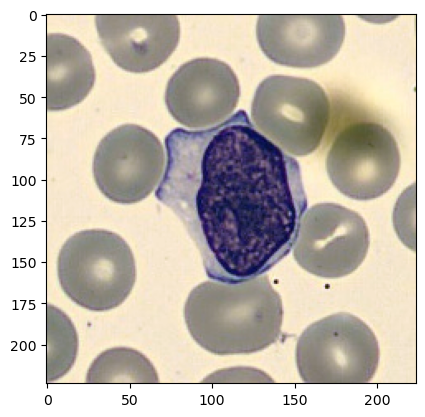

In [56]:
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
img_array = np.array(instance_image)

# Supposons que instance_image est votre image PIL d'origine
# img_array = np.array(instance_image)

# Votre code pour calculer les composantes principales
original_shape = img_array.shape
img_array = img_array.reshape(-1, 3).astype(np.float32)

# Calcul des composantes principales
mean = np.mean(img_array, axis=0)
img_array_centered = img_array - mean

pca = PCA(n_components=3)
pca.fit(img_array_centered)

# Application de bruit PCA
noise = np.random.normal(0, 0.1, (1, 3)) * np.sqrt(pca.explained_variance_)
new_image_centered = img_array_centered + noise

# Remettre les données centrées dans leur gamme d'origine
new_image = new_image_centered + mean
new_image=new_image.reshape(original_shape)
# Assurer que les valeurs soient dans l'intervalle [0, 255] et convertir en uint8
import numpy as np

# Supposons que new_image est votre tableau d'images modifié
# new_image a la forme (hauteur, largeur, 3) pour une image RGB

# Initialiser un tableau vide pour stocker l'image normalisée
new_image_normalized = np.zeros_like(new_image, dtype=np.float32)

# Traiter chaque canal séparément
for c in range(3):  # Il y a 3 canaux dans une image RGB
    # Sélectionner le canal
    channel = new_image[:, :, c]
    
    # Calculer le min et max du canal
    min_val = channel.min()
    max_val = channel.max()
    
    # Normaliser le canal
    channel_normalized = (channel - min_val) / (max_val - min_val) * 255
    
    # Stocker le canal normalisé dans le tableau résultant
    new_image_normalized[:, :, c] = channel_normalized

# Convertir l'image normalisée en uint8
new_image_normalized_uint8 = new_image_normalized.astype(np.uint8)


# Convertir en image PIL et afficher

plt.imshow(new_image_normalized_uint8)


In [195]:
def Add_PCA_noise(image):
    img_array=np.array(image)
    original_shape = img_array.shape
    img_array = img_array.reshape(-1, 3).astype(np.float32)
    mean = np.mean(img_array, axis=0)
    img_array_centered = img_array - mean
    pca = PCA(n_components=3)
    pca.fit(img_array_centered)
    noise = np.random.normal(0, 0.1, (1, 3)) * np.sqrt(pca.explained_variance_)
    new_image_centered = img_array_centered + noise
    new_image = new_image_centered + mean
    new_image=new_image.reshape(original_shape)
    new_image_clipped = np.clip(new_image, 0, 255).astype(np.uint8)
    return Image.fromarray(new_image_clipped)

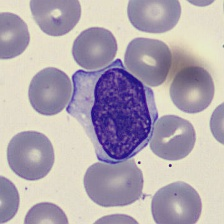

In [201]:
Add_PCA_noise(instance_image)

652288.0
-1.0


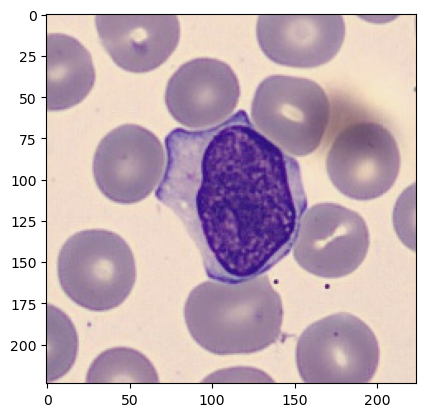

In [194]:
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA

# Supposons que instance_image est votre image PIL d'origine
img_array = np.array(instance_image)

# Votre code pour calculer les composantes principales
original_shape = img_array.shape
img_array = img_array.reshape(-1, 3).astype(np.float32)

# Calcul des composantes principales
mean = np.mean(img_array, axis=0)
img_array_centered = img_array - mean

pca = PCA(n_components=3)
pca.fit(img_array_centered)

# Application de bruit PCA
noise = np.random.normal(0, 0.1, (1, 3)) * np.sqrt(pca.explained_variance_)
new_image_centered = img_array_centered + noise

# Remettre les données centrées dans leur gamme d'origine
new_image = new_image_centered + mean

# Assurer que les valeurs soient dans l'intervalle [0, 255] et convertir en uint8
new_image_clipped = np.clip(new_image, 0, 255).astype(np.uint8)
print(np.sum(np.abs(new_image_clipped.reshape(original_shape)-img_array.reshape(original_shape))))
print(np.max((new_image_clipped.reshape(original_shape)-img_array.reshape(original_shape))))

# Convertir en image PIL et afficher
image_pil = Image.fromarray(new_image_clipped.reshape(original_shape))

plt.imshow(image_pil)

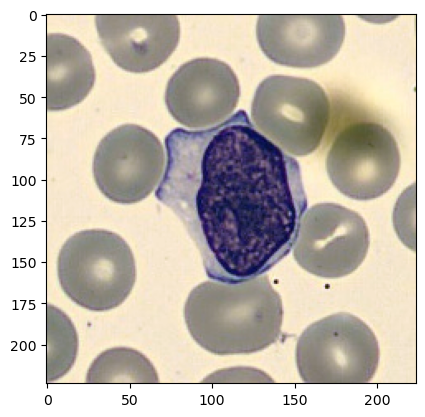

In [98]:
import numpy as np
img_array = np.array(instance_image)

# Supposons que instance_image est votre image PIL d'origine
# img_array = np.array(instance_image)

# Votre code pour calculer les composantes principales
original_shape = img_array.shape
img_array = img_array.reshape(-1, 3).astype(np.float32)

# Calcul des composantes principales
mean = np.mean(img_array, axis=0)
img_array_centered = img_array - mean

pca = PCA(n_components=3)
pca.fit(img_array_centered)

# Application de bruit PCA
noise = np.random.normal(0, 0.00000001, (1, 3)) * np.sqrt(pca.explained_variance_)
new_image_centered = img_array_centered + noise

# Remettre les données centrées dans leur gamme d'origine
new_image = new_image_centered + mean
new_image=new_image.reshape(original_shape)
# Assurer que les valeurs soient dans l'intervalle [0, 255] et convertir en uint8
import numpy as np
# Supposons que new_image est votre tableau d'images modifié
# Trouver le minimum et le maximum de new_image
min_val = new_image.min()
max_val = new_image.max()

# Renormaliser les données pour que les valeurs soient entre 0 et 255
new_image_normalized = (new_image - min_val) / (max_val - min_val) * 255

# Convertir en uint8 pour l'image
new_image_uint8 = new_image_normalized.astype(np.uint8)
plt.imshow(new_image_normalized_uint8)

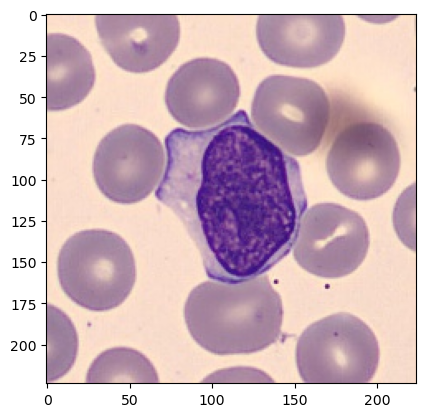

In [54]:
plt.imshow(instance_image)

In [30]:
import numpy as np
from PIL import Image

# Supposons que new_image est votre tableau numpy modifié

# 1. Normaliser les valeurs si nécessaire (assurez-vous que c'est ce que vous voulez)
# new_image = np.clip(new_image, 0, 255)

# 2. Convertir en uint8
new_image_uint8 = new_image.astype(np.uint8)

# 3. Convertir en image PIL et afficher
image_pil = Image.fromarray(new_image_uint8.reshape(original_shape))
print(image_pil)


<PIL.Image.Image image mode=RGB size=224x224 at 0x7F610532CFD0>


In [29]:
img_array = np.array(instance_image)
original_shape = img_array.shape
img_array = img_array.reshape(-1, 3).astype(np.float32)
print(img_array.shape)
# Calcul des composantes principales
mean = np.mean(img_array, axis=0)
img_array = (img_array - mean)
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(img_array)
v = pca.components_
lamb=pca.explained_variance_
v, lamb
noise=np.random.normal(0, 0.1, (1, 3))*np.sqrt(pca.explained_variance_)
new_image = img_array + noise
print(Image.fromarray(new_image.reshape(original_shape)))

(50176, 3)


TypeError: Cannot handle this data type: (1, 1, 3), <f8

In [25]:
cov=np.cov(img_array, rowvar=False)
eigen_values, eigen_vectors = np.linalg.eig(cov)
eigen_values, eigen_vectors

(array([6041.27268767,   10.80622672,   55.76902493]),
 array([[-0.64033778, -0.75877051, -0.11930981],
        [-0.70656831,  0.64281081, -0.29589775],
        [-0.30121213,  0.10517398,  0.94773925]]))

torch.Size([3, 224, 224])


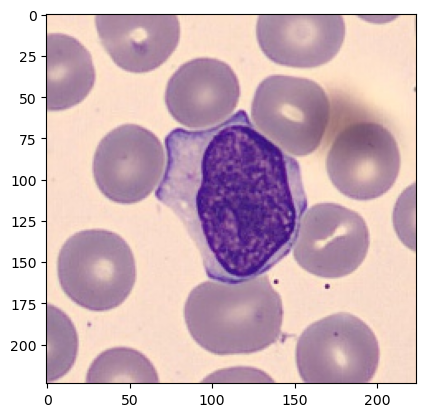

In [11]:
instance_image = Image.open('/users/eleves-b/2020/damien.vilcocq/Desktop/DL/trainset/P0/000000.jpg')

# Convert the image to a tensor
im_tensor = transforms.ToTensor()(instance_image)
print(im_tensor.shape)
# Permute the tensor dimensions to have the channel as the last dimension
im = im_tensor.permute(1, 2, 0)

# Convert tensor to numpy for displaying
im_numpy = im.numpy()

# Display the image
plt.imshow(im_numpy)
plt.show()

In [53]:
len(all_images)

97

In [61]:
np.dot(all_images_np, selected_vectors[:,:1])

array([[-1.49802562],
       [-1.49802562],
       [-1.5067075 ],
       ...,
       [-1.13239001],
       [-1.20138906],
       [-1.25072232]])

In [56]:
all_images_np=np.array(all_images_np[0:224*224])

In [68]:
print(reconstructed_image.shape)

(224, 224, 3)

In [85]:
X = img.reshape(-1,3)
pca = PCA(n_components=3)
pca.fit(X)
v = pca.components_
projected = np.dot(X, v.T).reshape((224,224,3))

array([[-0.6376087 , -0.75100896, -0.1715829 ],
       [-0.70909981,  0.65920364, -0.25025591],
       [-0.30105251,  0.03789594,  0.95285428]])

In [144]:


# Sélectionnez les premiers n vecteurs propres
for i in range(3):
    selected_vectors = v[1,:i]

    # Projetez les images sur ces vecteurs pour obtenir les scores PCA
    pca_scores = np.dot(all_images_np, selected_vectors)

    # Reconstruisez les images à partir des scores PCA
    # (Remarque: il faut ajouter la moyenne si les données ont été centrées)
    reconstructed_images = np.dot(pca_scores, selected_vectors.T)

    # Visualisez une image originale et sa reconstruction
    img_index = 0  # Changer pour visualiser différentes images
    original_image = all_images_np.reshape(224, 224, 3)  # Ajustez la forme selon vos données
    print(reconstructed_images.shape)
    reconstructed_image = reconstructed_images.reshape(224, 224, 3)  # Idem

    # Affichage
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(original_image, cmap='gray')
    ax[0].set_title('Original Image')
    ax[1].imshow(reconstructed_image[:,:,1], cmap='gray')
    ax[1].set_title('Reconstructed Image')

ValueError: shapes (402010112,3) and (0,) not aligned: 3 (dim 1) != 0 (dim 0)

TypeError: Invalid shape (3, 224, 224) for image data

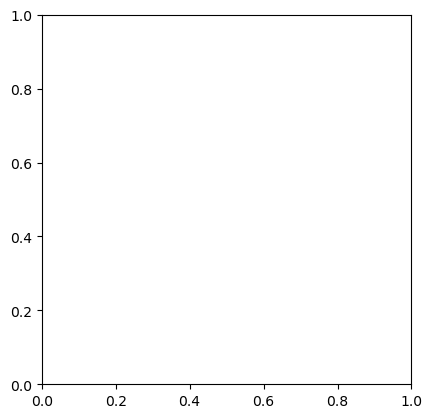

In [26]:
import cv2
instance_image = Image.open('/users/eleves-b/2020/damien.vilcocq/Desktop/DL/trainset/P0/000000.jpg')
im=transforms.ToTensor()(instance_image)
im=im.view(3,224,224)
im=im.cpu().numpy()
plt.imshow(im)

In [15]:
img=cv2.imread('/users/eleves-b/2020/damien.vilcocq/Desktop/DL/trainset/P0/000000.jpg')
print(img/255)

[[[0.80392157 0.8745098  0.99607843]
  [0.80392157 0.8745098  0.99607843]
  [0.80784314 0.86666667 0.99215686]
  ...
  [0.79607843 0.8745098  0.97254902]
  [0.8        0.89411765 0.98039216]
  [0.73333333 0.84705882 0.92941176]]

 [[0.79607843 0.86666667 0.98823529]
  [0.79607843 0.86666667 0.98823529]
  [0.79607843 0.86666667 0.98823529]
  ...
  [0.8        0.87843137 0.97647059]
  [0.79607843 0.89019608 0.97647059]
  [0.7254902  0.83137255 0.91372549]]

 [[0.79215686 0.8745098  0.98431373]
  [0.79215686 0.8745098  0.98431373]
  [0.79607843 0.87843137 0.98823529]
  ...
  [0.79607843 0.89019608 0.98431373]
  [0.80784314 0.89019608 0.97647059]
  [0.7254902  0.80784314 0.89411765]]

 ...

 [[0.62352941 0.49411765 0.62745098]
  [0.63137255 0.50980392 0.63921569]
  [0.59215686 0.46666667 0.60392157]
  ...
  [0.79607843 0.8627451  0.96862745]
  [0.8        0.86666667 0.97254902]
  [0.79215686 0.85882353 0.96470588]]

 [[0.63529412 0.52941176 0.6627451 ]
  [0.63921569 0.54117647 0.6745098 ]


In [17]:
images=images.view((images.shape[0]*224*224*3)).cpu().numpy()

TypeError: Cannot interpret '3' as a data type

(array([4.83201954e-05, 4.69396140e-04, 1.58076053e-03, 9.85732263e-03,
        1.92314360e-02, 6.35686386e-02, 6.82488437e-02, 1.26950995e-01,
        9.14976984e-02, 1.44090863e-01, 1.03715799e-01, 1.75443908e-01,
        1.26094847e-01, 1.92942594e-01, 1.26895772e-01, 1.74491178e-01,
        1.53016296e-01, 9.03241407e-02, 1.19792701e-01, 6.96018096e-02,
        9.63228852e-02, 6.11250644e-02, 1.00409243e-01, 7.40748804e-02,
        1.23057766e-01, 8.89366625e-02, 1.47294024e-01, 1.06242174e-01,
        1.70584400e-01, 1.20896981e-01, 1.87074860e-01, 1.24687035e-01,
        1.85721896e-01, 1.78156878e-01, 1.12986285e-01, 1.59898234e-01,
        9.92153438e-02, 1.37657166e-01, 8.69143807e-02, 1.22291362e-01,
        7.95211388e-02, 1.24866510e-01, 9.51906687e-02, 1.78225907e-01,
        1.52815883e-01, 2.82734924e-01, 2.21141220e-01, 3.65886976e-01,
        2.54703107e-01, 3.95272522e-01, 4.23126900e-01, 3.22294342e-01,
        5.96306789e-01, 5.13409894e-01, 9.61126043e-01, 7.883661

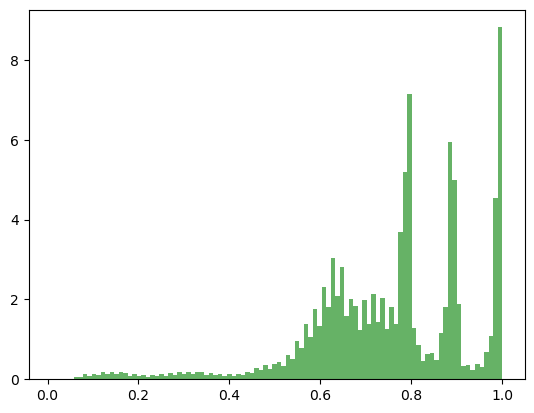

In [16]:
plt.hist(images, bins=100, density=True, alpha=0.6, color='g')

In [41]:
eigen_values, eigen_vectors = np.linalg.eig(cov_matrix)

In [42]:
eigen_values

array([0.09124663, 0.00019325, 0.0005737 ])

In [18]:
print(images)

[0.8       0.7882353 0.7764706 ... 0.6392157 0.6431373 0.6509804]


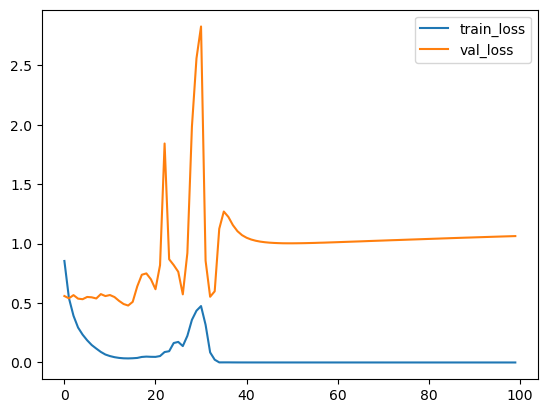

In [ ]:
plt.plot(list_train_loss, label='train_loss')
plt.plot(list_val_loss, label='val_loss')
plt.legend()


In [ ]:
c=0
for i in all_labels:
    if i==0:
        c+=1
print(c/len(all_preds))

0.12244897959183673


In [ ]:
print(len(all_labels))

AttributeError: 'DataLoader' object has no attribute 'labels'

In [ ]:
torch.exp(outputs)

tensor([0.8801, 0.1199])

In [ ]:
torch.cat((torch.exp(outputs).unsqueeze(0), (1-torch.exp(outputs)).unsqueeze(0)),0)

tensor([[0.8801, 0.1199],
        [0.1199, 0.8801]])

In [ ]:
u=torch.cat((torch.exp(outputs).unsqueeze(0), (1-torch.exp(outputs)).unsqueeze(0)),0)
torch.argmax(u,1)

tensor([0, 1])

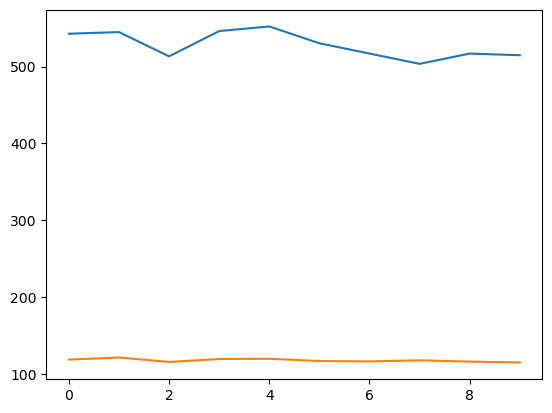

In [ ]:
plt.plot(list_train_loss, label='train_loss')
plt.plot(list_val_loss, label='val_loss')

In [ ]:
res.train()

CNN(
  (ResNet): ResNet(
    (conv1): Conv2d(3, 3, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (batch_norm1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Block(
        (conv1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (batch_norm1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (batch_norm2): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
    )
    (layer2): Sequential(
      (0): Block(
        (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (batch_norm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=

In [ ]:
print(outputs.shape)
print(labels.shape)

torch.Size([2])
torch.Size([1])


In [ ]:
outputs[0]

tensor(0.4137, grad_fn=<SelectBackward0>)

In [ ]:
accumulated_labels[0]

tensor([0])